# Data Analysis Sec 1

Part 1 of the data analysis for section 1: data processing and topic classfication.

## Load Data

In [2]:
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# from https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
from IPython.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

pd.set_option('display.max_colwidth', None)

In [3]:
df_frontpage = pd.read_parquet('../data/a1_data.parquet')

leanings = ['Left', 'Lean Left', 'Center', 'Lean Right', 'Right']
df_frontpage

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2023-12-18 19:08:10,959	INFO worker.py:1673 -- Started a local Ray instance.


,x,y,height,width,tag,text,name,date,leaning,end,entity,index,score,start,neg,pos,word_2,text_size
0,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,5.0,B-PER,1.0,0.8995158,0.0,0.831232,0.168768,Biden,128.645833
1,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,20.0,B-PER,4.0,0.99745303,15.0,0.831232,0.168768,Putin,128.645833
2,272,167,19,325,h2,Biden threaten Putin with sanctions over Ukraine,ABC-News-(Online),20220101000143,Lean Left,48.0,B-LOC,8.0,0.99974483,41.0,0.831232,0.168768,Ukraine,128.645833
3,272,207,19,324,h2,Coaches made teen eat pizza despite religion: Suit,ABC-News-(Online),20220101000143,Lean Left,NaN,None,NaN,None,NaN,0.865781,0.134220,None,123.120000
4,272,247,19,297,h2,Suspect arrested in shooting of police officers,ABC-News-(Online),20220101000143,Lean Left,NaN,None,NaN,None,NaN,0.907020,0.092980,None,120.063830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982432,653,9594,47,285,h3,Iowa is the Front Line in a Battle Over Carbon Pipelines,Time-Magazine,20220301204820,Lean Left,56.0,B-MISC,8.0,0.9759724,28.0,0.159295,0.840705,Battle Over Carbon Pipelines,239.196429
1982433,967,9594,71,285,h3,Russia Tensions Could Push Europe to a Clean Energy Future,Time-Magazine,20220301204820,Lean Left,6.0,B-LOC,1.0,0.999783,0.0,0.369156,0.630844,Russia,348.879310
1982434,967,9594,71,285,h3,Russia Tensions Could Push Europe to a Clean Energy Future,Time-Magazine,20220301204820,Lean Left,33.0,B-LOC,7.0,0.99859875,27.0,0.369156,0.630844,Europe,348.879310
1982435,967,9594,71,285,h3,Russia Tensions Could Push Europe to a Clean Energy Future,Time-Magazine,20220301204820,Lean Left,58.0,B-MISC,10.0,0.9695156,39.0,0.369156,0.630844,Clean Energy Future,348.879310


In [29]:
df = df_frontpage[["x", "y", "height", "width", "tag", "text", "name", "date", "leaning"]]
df.rename(columns={'name': 'media_name'}, inplace=True)
df.drop_duplicates(subset=['text'], inplace=True)

In [39]:
df = df.reset_index(drop = True)
df = df.sample(5, random_state = 42)
df['date'] = pd.to_datetime(df['date'])
df

,x,y,height,width,tag,text,media_name,date,leaning
114085,8,12828,26,694,a,Ted Cruz introduces bill to 'restore American energy independence’,Fox-News-(Online-News),2022-03-05 06:06:18,Right
198660,676,5171,48,358,span,Natural Immunity Protects Against Omicron Variant: Study,The-Epoch-Times,2022-02-19 10:41:57,Lean Right
10245,659,500,56,532,h4,Russia-Ukraine updates: Ukrainian forces in Mariupol given until 4 am to surrender,ABC-News-(Online),2022-03-21 06:21:05,Lean Left
170804,810,3497,39,350,a,How Elizabeth II's Staff Confirmed She Was Queen via the Radio 70 Years Ago,Newsweek,2022-02-06 10:37:55,Center
163117,1236,2220,100,341,div,"Graham vowed to be the president's ""best ally"" in the Senate if Biden shows ""what will happen to the Chinese economy if they bail out this war criminal Putin.""",Newsweek,2022-03-15 16:46:57,Center


# Headline Processing

In [110]:
df_headlines = df_frontpage.drop_duplicates(subset="text")
df_headlines = df_headlines.sample(n = 1000, random_state = 42)
df_headlines = df_headlines[["text"]]

In [111]:
df_headlines

,text
833713,Ted Cruz introduces bill to 'restore American energy independence’
1623183,Natural Immunity Protects Against Omicron Variant: Study
59183,Russia-Ukraine updates: Ukrainian forces in Mariupol given until 4 am to surrender
1411481,How Elizabeth II's Staff Confirmed She Was Queen via the Radio 70 Years Ago
1356568,"Graham vowed to be the president's ""best ally"" in the Senate if Biden shows ""what will happen to the Chinese economy if they bail out this war criminal Putin."""
...,...
1609215,Homeless man charged in death of woman fatally stabbed in NYC
1659418,‘I was looking for new hair – new me. The salon booked me in with JP’
457019,"Latvian Aigars Balsevics, 41, appeared before magistrates in Peterborough today accused of raping a woman in Wisbech, Cambridgeshire, in May last year."
254817,Mini plant production halted due to chip shortage


In [122]:
for x in df_headlines.iterrows():
    print(x[0])
    print(x[1]["text"])
    break

833713
Ted Cruz introduces bill to 'restore American energy independence’


In [ ]:
# Optionally, write to a file
with open('label_fine_tune.txt', 'w') as file:
    for x in df_headlines.iterrows():
        s = str(x[0]) + "\t" + str((x[1]["text"])) + "\t\n"
        file.write(s)


In [56]:
import nltk
from nltk.corpus import stopwords

from gensim.utils import tokenize
from gensim.parsing.preprocessing import remove_stopwords, remove_stopword_tokens
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.corpora import Dictionary
from gensim import corpora, models

def filter_out_stopwords(doc):
    new_doc = []

    for sentence in doc:
        new_sentence = [word for word in sentence if not word.lower() in stop_words]
        new_doc.append(new_sentence)
        
    return new_doc

# filter_out_stopwords(doc[:10])

In [61]:
leaning = ['Left', 'Lean Left', 'Center', 'Lean Right', 'Right']
stop_words = set(stopwords.words('english')) # nltk stopwords

documents = []
for x in leaning:
    doc = df_frontpage[df_frontpage["leaning"] == x]["text"].drop_duplicates()
    doc = [remove_stopwords(text) for text in doc]
    doc = [list(tokenize(text)) for text in doc]
    doc = filter_out_stopwords(doc) # filter out nltk stopwords

    documents.append(doc)

In [6]:
leanings = ['Left', 'Lean Left', 'Center', 'Lean Right', 'Right']
df_grouped = df_frontpage.groupby('leaning')

dfs_words = []
for x in leanings:
    grouped = df_grouped.get_group(x)["word_2"].value_counts()[0:15]
    df = grouped.to_frame()
    # df = df.style.applymap(color_rows, axis = 1)
    dfs_words.append(df)

display_side_by_side(dfs_words, leanings) 

(_deploy_ray_func pid=30157) SettingWithCopyWarning: 
(_deploy_ray_func pid=30157) A value is trying to be set on a copy of a slice from a DataFrame
(_deploy_ray_func pid=30157) 
(_deploy_ray_func pid=30157) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,count
word_2,
Ukraine,895
Trump,781
Russia,769
Biden,447
US,407
Putin,407
Republican,286
America,259
GOP,211


In [7]:
# normalized version

NER_counts = df_frontpage["name"].value_counts()
NER_counts = NER_counts.to_dict()

def get_count(x):
    return 1 / NER_counts[x]

In [ ]:
leanings = ['Left', 'Lean Left', 'Center', 'Lean Right', 'Right']

df_frontpage["NER_counts"] = df_frontpage["name"].apply(get_count)
df_frontpage

In [9]:
df_grouped = df_frontpage.groupby('leaning')

dfs_words_norm = []
for x in leanings:
    grouped = df_grouped.get_group(x).groupby('word_2')
    grouped_sum = grouped['NER_counts'].sum()
    most_salient_words = grouped_sum.nlargest(30)
    
    dfs_words_norm.append(most_salient_words.to_frame())

display_side_by_side(dfs_words_norm, leanings) 

(_deploy_ray_func pid=30161) SettingWithCopyWarning: 
(_deploy_ray_func pid=30161) A value is trying to be set on a copy of a slice from a DataFrame
(_deploy_ray_func pid=30161) 
(_deploy_ray_func pid=30161) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,NER_counts
word_2,
Ukraine,0.377248
Russia,0.321026
Trump,0.296524
Putin,0.186057
Biden,0.178882
US,0.167741
America,0.149002
Republican,0.117773
GOP,0.100190


# Topics classfication

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
df_frontpage = pd.read_parquet('../processed_data/a1_data.parquet')

leanings = ['Left', 'Lean Left', 'Center', 'Lean Right', 'Right']
df = df_frontpage.drop_duplicates(subset = "text").groupby("leaning")

dfs = []
for x in leanings:
    grouped = df.get_group(x)
    dfs.append(grouped.sample(n = 1000, random_state = 42)) 
df = pd.concat(dfs, ignore_index=True)
df = df[["x", "y", "height", "width", "text", "name", "leaning"]]

In [4]:
# Path to your text file
file_path = './label_full_result.txt'

# Reading the file and storing each line in a list
with open(file_path, 'r') as file:
    lines = [line.strip() for line in file]

# lines is now a list where each element is a line from the file
for x in lines:
    try:
        n = int(x.split("\t")[0])
    except:
        print(x)        

In [ ]:
col_to_cancat = [x.split("\t")[-1] for x in lines] 
col_to_cancat = [x.split("/") for x in col_to_cancat]
news_type = ["Domestic news", "Political News", "Economic News", "Entertainment News"]

df_to_cancat = pd.DataFrame(col_to_cancat, columns = news_type)
df = pd.concat([df, df_to_cancat], axis = 1, ignore_index=False)
df

In [7]:
df_grouped = df.groupby("leaning")

graph = []
for x in leanings:
    grouped = df_grouped.get_group(x)
    for y in news_type:
        count = grouped.value_counts(y)["True"] / len(grouped) 
        row = [x, y, count]
        graph.append(row)

df_graph = pd.DataFrame(graph, columns = ["Leanings", "Topic", "Percentage of headlines"])

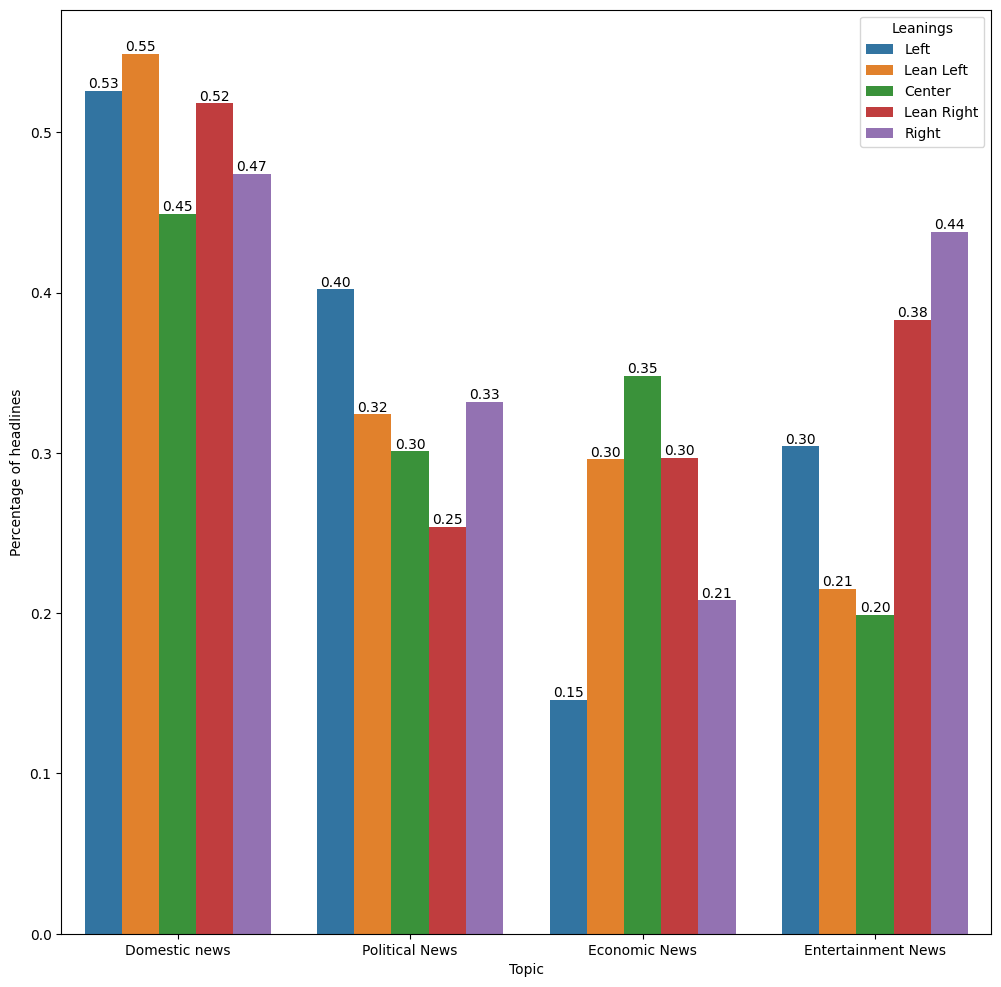

In [9]:
plt.figure(figsize=(12, 12))
ax = sns.barplot(data = df_graph, x = "Topic", y = "Percentage of headlines", hue = "Leanings")

for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')
